In [43]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import partial_dependence
import collections as c
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 30}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
import random
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
import warnings
warnings.filterwarnings('ignore')

In [44]:
gb_model = pickle.load(open('gradient_boost_completion_first_quarter.p', 'rb')) # load the model

In [45]:
gb_model.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=50,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)>

In [46]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='blue')
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [47]:
X_test = pd.read_csv('../data/processed/first_quarter/X_test.csv')
y_test = pd.read_csv('../data/processed/first_quarter/y_test.csv')
y_test = y_test['module_not_completed']

# fill
X_test.fillna(value = 0, inplace = True)

In [48]:
    predictions = gb_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = gb_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

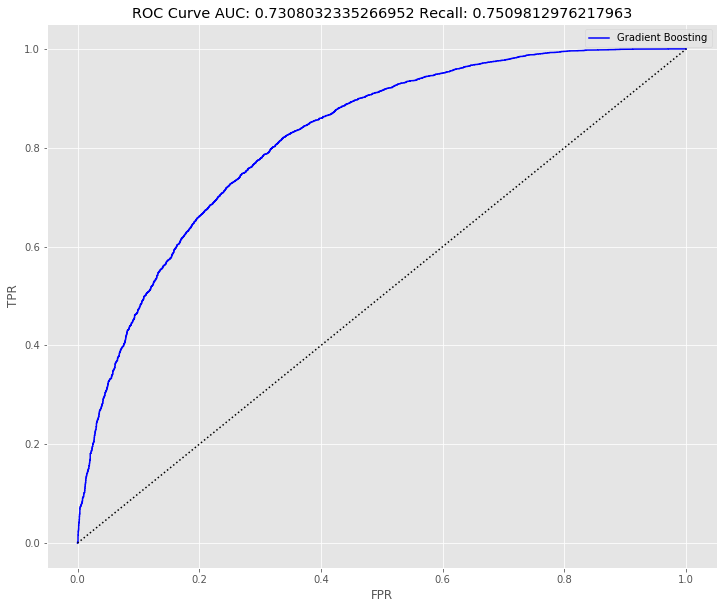

Best Model: GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5, min_samples_split=50,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.5, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

Roc Auc: 0.7308032335266952

Recall Score: 0.7509812976217963

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.86      0.80      5026
        True       0.75      0.61      0.67      3636

   micro avg       0.75      0.75      0.75      8662
   macro avg       0.75      0.73      0.74      8662
weighted avg       0.75      0.75      0.75      8662


Confusion Matrix:
 [[2

In [49]:
    print_roc_curve(y_test, probas, 'Gradient Boosting')
    print('Best Model: {}'.format(gb_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

## Model Improvement Over Baseline

In [54]:
proportion = y_test.sum() / y_test.shape[0] # proportion of student who do not complete
baseline_probas = np.array([proportion] * len(y_test)) # baseline probability

In [55]:
# randomly pedict proportion = true
baseline_preds = []
for n in range(len(y_test)):
    if random.random() < proportion:
        baseline_preds.append(True)
    else:
        baseline_preds.append(False)

In [56]:
    bl_roc_auc = roc_auc_score(y_test, baseline_preds)
    probas = baseline_probas
    bl_recall = recall_score(y_test, baseline_preds, average='micro')
    bl_class_report = classification_report(y_test, baseline_preds)

## Baseline:

In [57]:
    print('\nBaseline Roc Auc: {}'.format(bl_roc_auc))
    print('\nBaseline Recall Score: {}'.format(bl_recall))
    print('\nBaseline Classification Report:\n {}'.format(bl_class_report))
    print('\nBaseline Confusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, baseline_preds)))


Baseline Roc Auc: 0.4995806186269244

Baseline Recall Score: 0.5129300392519048

Baseline Classification Report:
               precision    recall  f1-score   support

       False       0.58      0.58      0.58      5026
        True       0.42      0.42      0.42      3636

   micro avg       0.51      0.51      0.51      8662
   macro avg       0.50      0.50      0.50      8662
weighted avg       0.51      0.51      0.51      8662


Baseline Confusion Matrix:
 [[1514 2097]
 [2122 2929]]


## Gradient Boosting Model:

In [29]:
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))


Roc Auc: 0.7308032335266952

Recall Score: 0.605060506050605

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.86      0.80      5026
        True       0.75      0.61      0.67      3636

   micro avg       0.75      0.75      0.75      8662
   macro avg       0.75      0.73      0.74      8662
weighted avg       0.75      0.75      0.75      8662


Confusion Matrix:
 [[2200  721]
 [1436 4305]]


## Choosing a Threshold

In [30]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:200]

,fprs,tprs,Thresholds
800,0.130638,0.541783,0.738569
1000,0.169692,0.614405,0.699054
1200,0.209846,0.673498,0.662775
1400,0.250000,0.725428,0.626675
1600,0.293179,0.770991,0.590364
1800,0.341034,0.822722,0.545064
2000,0.399340,0.859928,0.496630
2200,0.465072,0.900517,0.442405
2400,0.537954,0.932153,0.375795
2600,0.629263,0.961003,0.296579


In [31]:
    t = 0.5 # threshold for predicting positive    
    predictions = (gb_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.5:
               precision    recall  f1-score   support

       False       0.75      0.86      0.80      5026
        True       0.75      0.61      0.67      3636

   micro avg       0.75      0.75      0.75      8662
   macro avg       0.75      0.73      0.74      8662
weighted avg       0.75      0.75      0.75      8662


Confusion Matrix at Threshold 0.5:
 [[2200  721]
 [1436 4305]]


In [32]:
    t = 0.4 # threshold for predicting positive    
    predictions = (gb_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.4:
               precision    recall  f1-score   support

       False       0.79      0.76      0.77      5026
        True       0.68      0.72      0.70      3636

   micro avg       0.74      0.74      0.74      8662
   macro avg       0.74      0.74      0.74      8662
weighted avg       0.74      0.74      0.74      8662


Confusion Matrix at Threshold 0.4:
 [[2602 1204]
 [1034 3822]]


In [33]:
    t = 0.3 # threshold for predicting positive    
    predictions = (gb_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.3:
               precision    recall  f1-score   support

       False       0.83      0.61      0.71      5026
        True       0.61      0.83      0.70      3636

   micro avg       0.70      0.70      0.70      8662
   macro avg       0.72      0.72      0.70      8662
weighted avg       0.74      0.70      0.70      8662


Confusion Matrix at Threshold 0.3:
 [[3020 1949]
 [ 616 3077]]


In [34]:
    t = proportion # threshold for predicting positive    
    predictions = (gb_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.33567943348158386:
               precision    recall  f1-score   support

       False       0.82      0.67      0.74      5026
        True       0.63      0.79      0.70      3636

   micro avg       0.72      0.72      0.72      8662
   macro avg       0.73      0.73      0.72      8662
weighted avg       0.74      0.72      0.72      8662


Confusion Matrix at Threshold 0.33567943348158386:
 [[2880 1656]
 [ 756 3370]]


## Feature Importance

In [36]:
features=list(range(len(X_train.columns)))

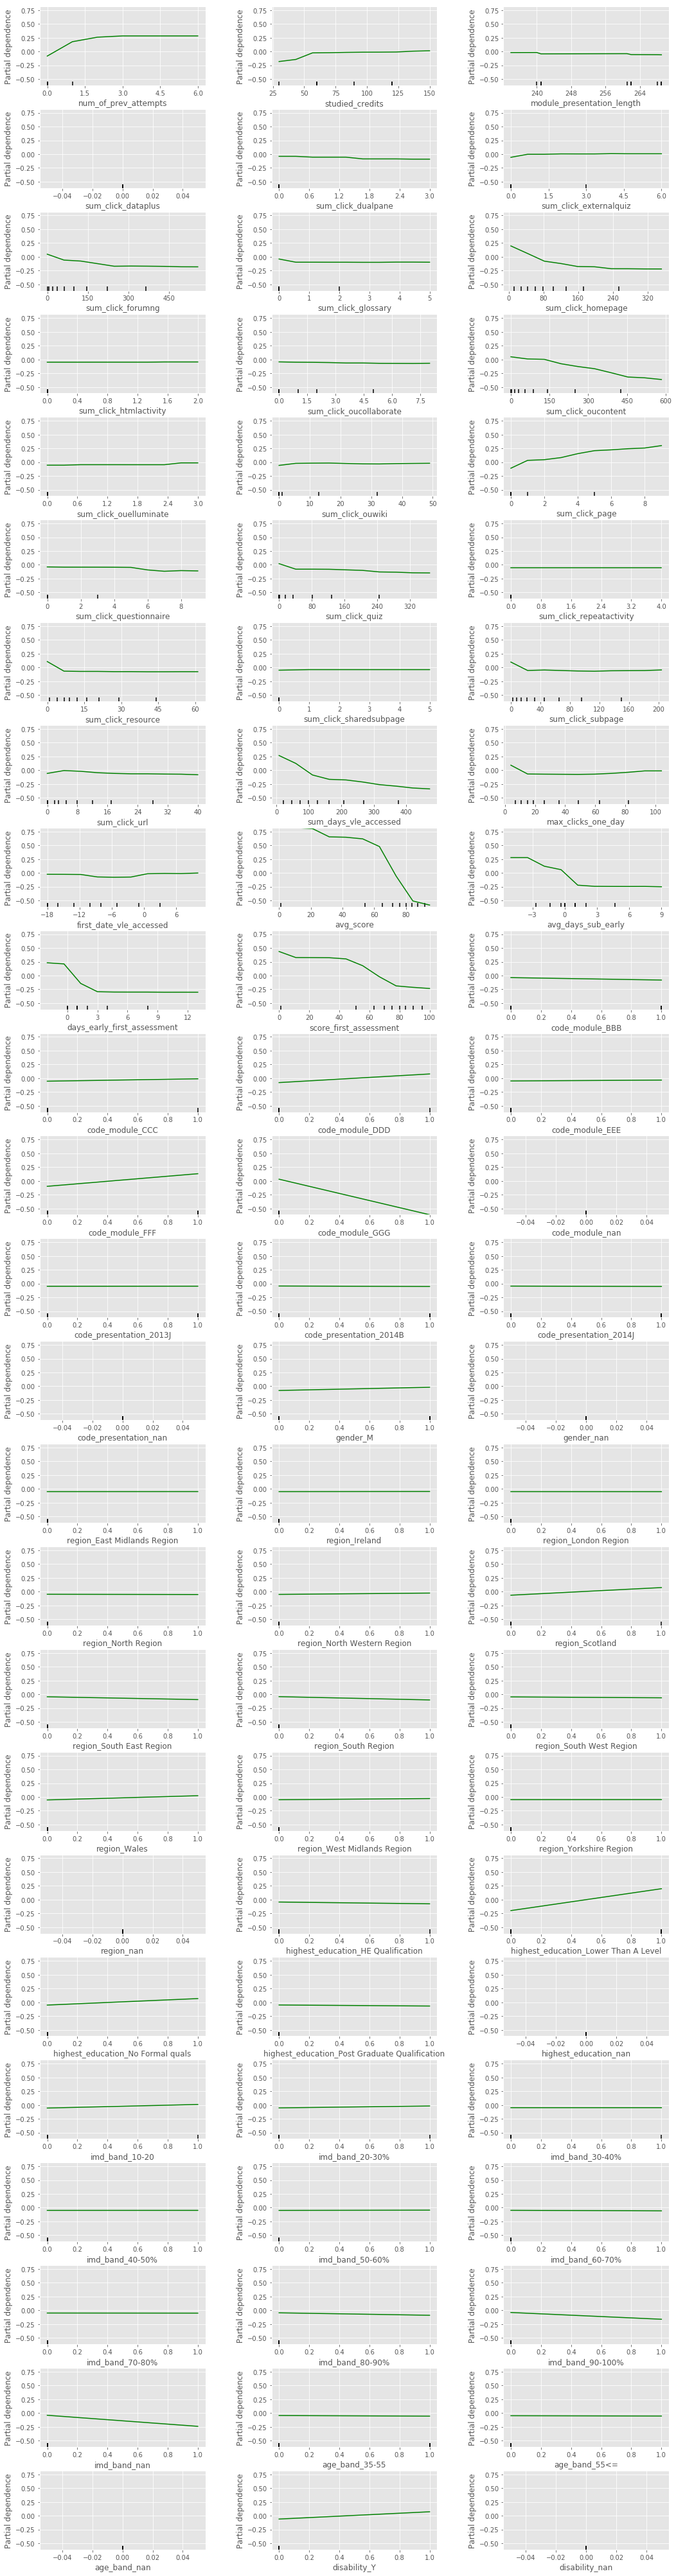

In [37]:
feat = []
for n in range(75):
    feat.append(n)
fig, ax = plot_partial_dependence(gb_model, X=X_train, features=feat, feature_names=X_train.columns[feat], grid_resolution=10)
fig.set_figwidth(16)
fig.set_figheight(100)

In [13]:
# pickle.dump(model, open('gradient_boost_completion.p', 'wb')) # save the model